# Intraday vs Overnight Momentum

- Momentum is a widely used trading strategy in quantitative finance. The core idea is that assets that have performed well in the past will continue to perform well in the near future. We are now going to think a little bit about past literature and create a better version of momentum. 
- There is an observation that overnight and intraday returns diﬀer. The paper "Tug of War: Overnight versus Intraday Expected Returns" by Polk, Sapienza, and Subrahmanyam explores how expected returns manifest diﬀerently during overnight and intraday periods.

## Information Events


### Earnings Announcements
- Earnings are typically announced outside of market hours, either **after market close** or **before market open**.

### Macro Announcements
- Major macroeconomic data like **Non-Farm Payroll** report are typically announced **before the market opens**, usually at **8:30 AM EST** on the first Friday of every month.
- Other macro data releases such as **CPI (Consumer Price Index)**, **GDP**, and **interest rate decisions** can be announced before or during market hours depending on the timing.
- Macro announcements can have a broad impact on investor sentiment and expectations for the overall economy. Certain sectors can be directly impacted by macroeconomic news.

## Loading Data (CRSP)

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

path = '/Users/Mike_Home/Quant_Data_Local'

if os.path.exists(path) == True:
    data_folder = os.path.abspath(path)
    os.chdir(data_folder)
    print(f'Successfully connected to data')
else:
    print('invalid data path!')

Successfully connected to data


### Read Data and Create Lags

In [ ]:
import duckdb

con = duckdb.connect()

query_create_lags = '''
SELECT 
    permno, 
    date, 
    ret,
    prc,
    shrout,
    shrcd,
    hexcd,
    abs(prc*shrout) AS mcap,
    lag(abs(prc*shrout)) over (PARTITION BY permno ORDER BY date) AS mcap_lag1,
    lag(ret,2) over (PARTITION BY permno ORDER BY date) AS ret_lag2,
    lag(prc) over (PARTITION BY permno ORDER BY date) AS prc_lag1,
    lag(prc,13) over (PARTITION BY permno ORDER BY date) AS prc_lag13,
    lag(ret) over (PARTITION BY permno ORDER BY date) AS ret_lag1
FROM read_parquet('crsp.msf_delisting_adjusted.parquet')
'''

crsp_msf_df = con.execute(query_create_lags).fetch_df()

### Impose Filters
- common equity sharecodes
- new york exchanges 
- $r_{t-2}$ not missing
- $mcap_{t-1}$ not missing
- $prc_{t-13}$ not missing
- $prc_{t-1}>1$
- at least 8 valid returns

In [3]:
# get the number of non-null return values for the past 11 months
crsp_msf_df['rollvalidobs'] = (
    crsp_msf_df
    .assign(boolean_retisnull=crsp_msf_df['ret'].notnull())
    .groupby('permno')['boolean_retisnull']
    .rolling(11) # rolling sum
    .sum()
).reset_index([0], drop=True)

# impose filters
crsp_msf_df = crsp_msf_df[
    (
        crsp_msf_df['shrcd'].isin(set([10,11])) &   # common equity sharecodes
        crsp_msf_df['hexcd'].isin(set([1,2,3])) &   # new york exchanges
        crsp_msf_df['ret'].notnull() &              # has return this month
        crsp_msf_df['ret_lag2'].notnull() &         # non missing return 2 month ago
        crsp_msf_df['mcap_lag1'].notnull() &        # non missing market cap
        (np.abs(crsp_msf_df['prc_lag1']) >= 1) &      # non missing price and greater or equal to 1 
        (crsp_msf_df['rollvalidobs'] >= 8) &          # has at least 8 obs lately
        crsp_msf_df['prc_lag13'].notnull()          # not missing obs 13 months ago
    )
]

### Construct Momentum

In [ ]:
# faster rolling for 11 months
def rolling_prod(x):
    return (x.rolling(11).apply(np.prod, raw=True) - 1)

crsp_msf_df['retplus1'] = crsp_msf_df['ret'].fillna(0) + 1
crsp_msf_df['rollret_11'] = crsp_msf_df.groupby('permno')['retplus1'].apply(rolling_prod).reset_index(drop=True)

crsp_msf_df['mom'] = crsp_msf_df.groupby('permno')['rollret_11'].shift(2)

### Construct Intraday & Overnight Momentum

In [ ]:
# select a few stocks to calculate for simplicity
query_dsf = (
"""
SELECT *
FROM read_parquet('crsp_202401.dsf.parquet')
WHERE openprc IS NOT NULL AND
      prc IS NOT NULL AND
      cfacpr IS NOT NULL AND
      date >= '1992-01-01' AND
      permno IN (
        SELECT permno 
        FROM read_parquet('crsp_202401.dsf.parquet') 
        GROUP BY permno
        ORDER BY COUNT(*) DESC
        LIMIT 10
      )
""")

crsp_d_partial = con.execute(query_dsf).fetch_df()

# adjust prices
crsp_d_partial['adj_prc'] = (crsp_d_partial['prc'] 
                             * np.where(crsp_d_partial['cfacpr']>1, 
                                        crsp_d_partial['cfacpr'], 1/crsp_d_partial['cfacpr']))
crsp_d_partial['adj_openprc'] = (crsp_d_partial['openprc'] 
                             * np.where(crsp_d_partial['cfacpr']>1, 
                                        crsp_d_partial['cfacpr'], 1/crsp_d_partial['cfacpr']))

crsp_d_partial['date'] = pd.to_datetime(crsp_d_partial['date'])
crsp_d_partial.info()

In [ ]:
crsp_d_partial = crsp_d_partial.sort_values(['permno', 'date']).drop_duplicates()

processed_dfs = []

for permno in crsp_d_partial['permno'].unique():
    temp_df = crsp_d_partial[crsp_d_partial['permno'] == permno].copy()
    temp_df['ret_daily'] = temp_df['adj_prc'].pct_change()
    temp_df['ret_overnight'] = temp_df['adj_openprc'] / temp_df['adj_prc'].shift(1) - 1
    temp_df['ret_intraday'] = temp_df['adj_prc'] / temp_df['adj_openprc'] - 1
    temp_df[['ret_daily', 'ret_overnight', 'ret_intraday']].fillna(0)
    
    temp_df['mom'] = (
        (1+temp_df['ret_daily'])
        .rolling(11)
        .apply(np.prod, raw=True).shift(2)
    )
    temp_df['mom_intraday'] = (
        (1+temp_df['ret_intraday'])
        .rolling(11)
        .apply(np.prod, raw=True).shift(2)
    )
    temp_df['mom_overnight'] = (
        (1+temp_df['ret_overnight'])
        .rolling(11)
        .apply(np.prod, raw=True).shift(2)
    )

    processed_dfs.append(temp_df)

crsp_d_partial = pd.concat(processed_dfs).reset_index(drop=True)

### Reading From The Already Computed File

In [2]:
mom_df = pd.read_parquet('hw2_mfin7037_data.parquet')
mom_df['date'] = pd.to_datetime(mom_df['date'])
mom_df = mom_df[mom_df['date'] >= '1995-01-01']

## Analysis

### Intraday/Overnight Momentum Correlation

In [3]:
from tabulate import tabulate

# Calculate correlation matrix
corr_matrix = mom_df[['mom_intraday', 'mom', 'mom_overnight']].corr()
print("Correlation Matrix:")
print(tabulate(corr_matrix, headers='keys', tablefmt='rounded_grid'))

Correlation Matrix:
╭───────────────┬────────────────┬──────────┬─────────────────╮
│               │   mom_intraday │      mom │   mom_overnight │
├───────────────┼────────────────┼──────────┼─────────────────┤
│ mom_intraday  │       1        │ 0.599922 │       -0.693108 │
├───────────────┼────────────────┼──────────┼─────────────────┤
│ mom           │       0.599922 │ 1        │        0.104139 │
├───────────────┼────────────────┼──────────┼─────────────────┤
│ mom_overnight │      -0.693108 │ 0.104139 │        1        │
╰───────────────┴────────────────┴──────────┴─────────────────╯


### Data Filtering
- Kick out anything in the bottom 20% of market capitalisation.
- Kick out anything with a price less than 5 at that time.

In [4]:
# filtering
filtered_mom_df = mom_df[(
    (mom_df['mcap_bin'] > 2) &
    (mom_df['prc_lag1'] >= 5)
)]

### Report Tables
- Based on three factors: MOM, MOM_Intraday, MOM_Overnight, rank stocks into decile every month.
- Generate report tables: for each factor, construct Equal-weighted and Value-weighted portfolios for each bin on:
    - Daily return
    - Intraday return
    - Overnight return
- Also construct long/short portfolios
- Report mean portfolio returns and T-statistics.

In [5]:
# --- Helper: Apply quantiles within each date group ---
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)

In [6]:
filtered_mom_df_copy = filtered_mom_df.copy()
# apply quantiles for each factor: (vanilla) momentum, intraday momentum, overnight momentum
for factor in ['mom', 'mom_intraday', 'mom_overnight']:
    filtered_mom_df_copy[f'{factor}_bin'] = apply_quantiles(filtered_mom_df_copy, factor)

In [7]:
def analyze_strategy(data, factor):
    """
    Analyze the performance of a factor by creating tables.
    The function computes the average returns (including daily return, intraday return and overnight return)
    and t-statistics for each quantile of the factor, using both equal-weighted and value-weighted methods.
    """

    # step 1: form portfolios using both EW and VW, rebalance every month
    portfolios_ret = (
        data
        .groupby(['date', f'{factor}_bin'])
        .apply(
            lambda g: pd.Series({
                'EW': g['ret'].mean(),
                'VW': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum(),
                'EW_intraday': g['intraday_ret_month'].mean(),
                'VW_intraday': (g['intraday_ret_month'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum(),
                'EW_overnight': g['overnight_ret_month'].mean(),
                'VW_overnight': (g['overnight_ret_month'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
            }))
        .T.stack(0)
    )
    portfolios_ret['10-1'] = portfolios_ret[10] - portfolios_ret[1]

    # step 2: calculate average returns of all portfolios
    ret_mean = portfolios_ret.groupby(level=0).mean()

    # generating t-statistics table
    ret_tstat = (
        portfolios_ret
        .groupby(level=0)
        .apply(lambda x: x.mean()/x.std()*np.sqrt(len(x)))
    )
    
    return {
        'ret_mean': ret_mean,
        'ret_tstat': ret_tstat
    }

In [8]:
# run analysis on all factors
for factor in ['mom', 'mom_intraday', 'mom_overnight']:
    result = analyze_strategy(filtered_mom_df_copy, factor)
    
    # format as percentages
    formatted_ret_mean = result['ret_mean'].applymap(lambda x: f"{x:.2%}")
    print(f"\n{factor.upper()} - Mean Returns")
    print(tabulate(formatted_ret_mean, headers='keys', tablefmt='rounded_grid'))
    
    # format as percentages
    formatted_ret_tstat = result['ret_tstat'].applymap(lambda x: f"{x:.2f}")
    print(f"\n{factor.upper()} - T-Statistics")
    print(tabulate(formatted_ret_tstat, headers='keys', tablefmt='rounded_grid'))


MOM - Mean Returns
╭──────────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬────────┬────────┬────────╮
│              │ 1.0    │ 2.0   │ 3.0   │ 4.0   │ 5.0   │ 6.0   │ 7.0   │ 8.0   │ 9.0    │ 10.0   │ 10-1   │
├──────────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼────────┼────────┼────────┤
│ EW           │ 0.14%  │ 0.71% │ 0.86% │ 0.96% │ 1.00% │ 1.09% │ 1.01% │ 1.07% │ 1.09%  │ 1.41%  │ 1.27%  │
├──────────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼────────┼────────┼────────┤
│ EW_intraday  │ -0.83% │ 0.60% │ 0.88% │ 1.05% │ 0.97% │ 1.00% │ 0.79% │ 0.66% │ 0.41%  │ -0.04% │ 0.79%  │
├──────────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼────────┼────────┼────────┤
│ EW_overnight │ 1.62%  │ 0.54% │ 0.28% │ 0.20% │ 0.24% │ 0.30% │ 0.45% │ 0.65% │ 0.97%  │ 1.85%  │ 0.23%  │
├──────────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼────────┼────────┼────────┤

#### Observations:
- Intraday momentum predicts intraday future returns, overnight momentum predicts overnight future returns.
- Intraday momentum exhibits a reversal effect on overnight future returns, overnight momentum exhibits a reversal effect on intraday future returns.
- Total momentum predicts daily returns, but not as strong (examine the T-Statistics). Total momentum effects are diluted by component reversals.

### Independent Sort
- Sort on both intraday momemtum and overnight momentum, into 5 bins each.
- Report average returns, of both value-weighted portfolios and equal-weighted portfolios.

In [9]:
filtered_mom_df_copy = filtered_mom_df.copy()

for factor in ['mom_intraday', 'mom_overnight']:
    filtered_mom_df_copy[f'{factor}_bin'] = apply_quantiles(filtered_mom_df_copy, factor, bins=5)

# step 1: form both EW and VW portfolios every month
portfolios = (
    filtered_mom_df_copy
    .groupby(['date', 'mom_intraday_bin', 'mom_overnight_bin'])
    .apply(
        lambda g: pd.Series({
            'EW': g['ret'].mean(),
            'VW': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

# step 2: compute mean return across time
result_df = (
    portfolios
    .groupby(['mom_intraday_bin', 'mom_overnight_bin'])
    .apply(
        lambda g: pd.Series({
            'EW': g['EW'].mean(),
            'VW': g['VW'].mean()
        })
    ).reset_index()
)

In [10]:
from tabulate import tabulate

# report EW and VW portfolios in seperate tables
for col in ['EW', 'VW']:
    print(f"\n{col} Portfolio Mean Returns: ")
    print(
        tabulate(
            result_df
            .pivot(
                index='mom_intraday_bin',
                columns='mom_overnight_bin',
                values=col)
                .rename_axis('Overnight MOM Bin \u2192\n\nIntraday MOM Bin \u2193') # \u2192: right arrow \u2193 downward arrow
                .applymap(lambda x: f"{x:.2%}"),
            headers='keys',
            tablefmt='rounded_grid'
        )
    )


EW Portfolio Mean Returns: 
╭───────────────────────┬───────┬───────┬───────┬───────┬───────╮
│   Overnight MOM Bin → │ 1.0   │ 2.0   │ 3.0   │ 4.0   │ 5.0   │
│                       │       │       │       │       │       │
│    Intraday MOM Bin ↓ │       │       │       │       │       │
├───────────────────────┼───────┼───────┼───────┼───────┼───────┤
│                     1 │ 0.08% │ 0.46% │ 0.59% │ 0.70% │ 0.32% │
├───────────────────────┼───────┼───────┼───────┼───────┼───────┤
│                     2 │ 0.79% │ 0.88% │ 1.10% │ 1.14% │ 1.12% │
├───────────────────────┼───────┼───────┼───────┼───────┼───────┤
│                     3 │ 0.67% │ 1.08% │ 1.03% │ 1.15% │ 1.12% │
├───────────────────────┼───────┼───────┼───────┼───────┼───────┤
│                     4 │ 0.82% │ 1.08% │ 1.10% │ 1.17% │ 1.45% │
├───────────────────────┼───────┼───────┼───────┼───────┼───────┤
│                     5 │ 0.86% │ 1.19% │ 1.24% │ 1.40% │ 1.61% │
╰───────────────────────┴───────┴───────┴──────

#### Observation:
- Within each overnight momuntum bucket, there is a **increase in returns as intraday momentum increases**. This pattern is consistent across both weighting schemes. This suggests that intraday momentum is significant in explaining returns when controlling overnight momentum.
- Similarly, within each intraday bucket, we observe **increase in returns as overnight momentum increases**.
- Returns increase as both intraday and overnight momentum increase. We can take advantage of this by constructing long/short portfolio where we long bucket (5,5) and short bucket (1,1).

### Long/Short Portfolio on both Intraday/Overnight Momentums
- Compute Sharpe Ratio
- Draw profit&loss curve
- Alpha analysis
- Compare with long/short portfolio using total momentum.

#### Constructing Intraday/Overnight MOM long/short

In [11]:
day_night_long_short = pd.merge(
    portfolios.query('mom_intraday_bin==5 & mom_overnight_bin==5'),
    portfolios.query('mom_intraday_bin==1 & mom_overnight_bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

day_night_long_short['EW_long_short'] = day_night_long_short['EW_long'] - day_night_long_short['EW_short']
day_night_long_short['VW_long_short'] = day_night_long_short['VW_long'] - day_night_long_short['VW_short']

#### Constructing Total MOM long/short

In [12]:
filtered_mom_df_copy = filtered_mom_df.copy()
filtered_mom_df_copy['mom_bin'] = apply_quantiles(filtered_mom_df_copy, 'mom', bins=10)

mom_portfolios = (
    filtered_mom_df_copy
    .groupby(['date', 'mom_bin'])
    .apply(
        lambda g: pd.Series({
            'EW': g['ret'].mean(),
            'VW': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )
).reset_index()

mom_long_short = pd.merge(
    mom_portfolios.query('mom_bin==10'),
    mom_portfolios.query('mom_bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

mom_long_short['EW_long_short'] = mom_long_short['EW_long'] - mom_long_short['EW_short']
mom_long_short['VW_long_short'] = mom_long_short['VW_long'] - mom_long_short['VW_short']

#### Decile Plots

In [13]:
import matplotlib.pyplot as plt

def plot_bins(portfolios_df, bin_name, title=None, width = 0.35):

  plt.figure(figsize=(10, 6))

  # calculate mean return for each bin
  bins_mean_ret_df = (
    portfolios_df
    .groupby([bin_name])
    .apply(
      lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean(),
      })
    )
  )

  # plot
  x = np.arange(len(bins_mean_ret_df))
  fig, ax = plt.subplots()

  ax.bar(x - width/2, bins_mean_ret_df['VW'], width, alpha=0.7, label='VW')
  ax.bar(x + width/2, bins_mean_ret_df['EW'], width, alpha=0.7, label='EW')

  ax.set_xticks(x)
  ax.set_xticklabels([f"{int(bin)}" for bin in portfolios_df[bin_name].unique()])
  ax.set_xlabel('Bin')
  ax.set_ylabel('Mean Returns')
  ax.set_title(title)
  ax.legend()

  plt.show()

<Figure size 1000x600 with 0 Axes>

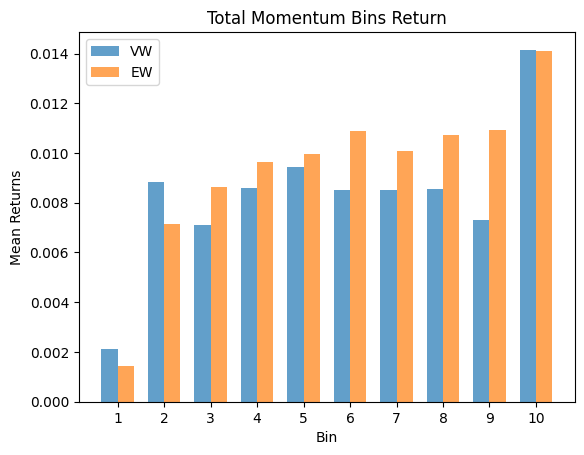

In [14]:
plot_bins(mom_portfolios, bin_name='mom_bin', title='Total Momentum Bins Return')

<Figure size 1000x600 with 0 Axes>

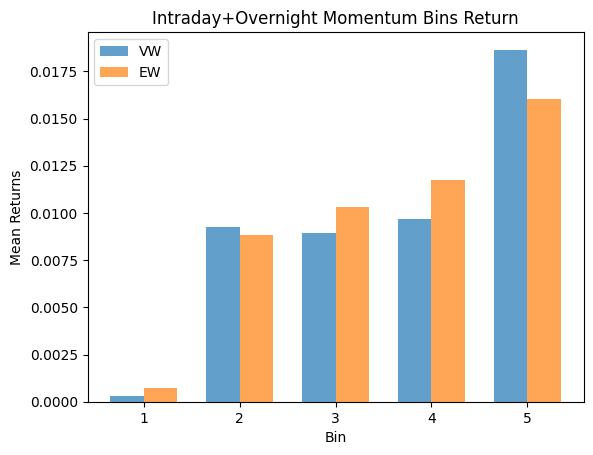

In [15]:
# reconstruct bins to be mom_intraday_bin == mom_overnight_bin
# portfolio_temp_df is for plotting bin graph only
portfolio_temp_df = portfolios.copy()
portfolio_temp_df['bin'] = (
    np.where(
        portfolio_temp_df['mom_intraday_bin'] == portfolio_temp_df['mom_overnight_bin'], 
        portfolio_temp_df['mom_intraday_bin'],
        np.nan
    )
)
portfolio_temp_df.dropna(subset=['bin'], inplace=True)
plot_bins(portfolio_temp_df, bin_name='bin', title='Intraday+Overnight Momentum Bins Return')

#### Profit & Loss

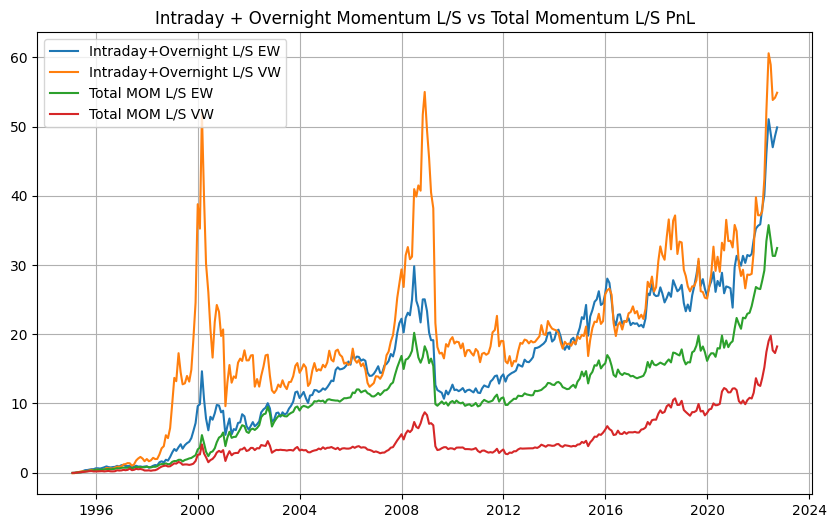

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot((1 + day_night_long_short.set_index('date')['EW_long_short']).cumprod() - 1, label='Intraday+Overnight L/S EW')
plt.plot((1 + day_night_long_short.set_index('date')['VW_long_short']).cumprod() - 1, label='Intraday+Overnight L/S VW')
plt.plot((1 + mom_long_short.set_index('date')['EW_long_short']).cumprod() - 1, label='Total MOM L/S EW')
plt.plot((1 + mom_long_short.set_index('date')['VW_long_short']).cumprod() - 1, label='Total MOM L/S VW')
plt.title("Intraday + Overnight Momentum L/S vs Total Momentum L/S PnL")
plt.legend()
plt.grid(True)
plt.show()

#### Sharpe Ratios

In [17]:
from tabulate import tabulate

def sharpe(returns, freq=12):
    return np.sqrt(freq) * returns.mean() / returns.std()

# Prepare data for tabulation
sharpe_results = [
    ["Intraday+Overnight Momentum L/S EW", f"{sharpe(day_night_long_short['EW_long_short']):.2f}"],
    ["Intraday+Overnight Momentum L/S VW", f"{sharpe(day_night_long_short['VW_long_short']):.2f}"],
    ["Total Momentum L/S EW", f"{sharpe(mom_long_short['EW_long_short']):.2f}"],
    ["Total Momentum L/S VW", f"{sharpe(mom_long_short['VW_long_short']):.2f}"]
]

# Print results in tabular format
print(tabulate(sharpe_results, headers=["Strategy", "Sharpe Ratio"], tablefmt="rounded_grid"))

╭────────────────────────────────────┬────────────────╮
│ Strategy                           │   Sharpe Ratio │
├────────────────────────────────────┼────────────────┤
│ Intraday+Overnight Momentum L/S EW │           0.64 │
├────────────────────────────────────┼────────────────┤
│ Intraday+Overnight Momentum L/S VW │           0.57 │
├────────────────────────────────────┼────────────────┤
│ Total Momentum L/S EW              │           0.69 │
├────────────────────────────────────┼────────────────┤
│ Total Momentum L/S VW              │           0.54 │
╰────────────────────────────────────┴────────────────╯


#### Regressions

In [18]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col


regression_df = pd.merge(
    mom_long_short,
    day_night_long_short,
    suffixes=['_X', '_y'],
    on='date'
)

# Against traditional momentum
X_ew = regression_df['EW_long_short_X'].rename('mom')
X_vw = regression_df['VW_long_short_X'].rename('mom')
y_ew = regression_df['EW_long_short_y']
y_vw = regression_df['VW_long_short_y']

ew_model = sm.OLS(y_ew, sm.add_constant(X_ew)).fit()
vw_model = sm.OLS(y_vw, sm.add_constant(X_vw)).fit()

# Against FF5 + traditional momentum
ff5_df = pd.read_parquet('ff.five_factor.parquet', engine='fastparquet')
ff5_df['mkt'] = ff5_df['mkt_rf'] + ff5_df['rf']
ff5_df['date'] = pd.to_datetime(ff5_df['dt'])

regression_df = pd.merge(
    regression_df,
    ff5_df,
    on='date'
)

X_ew = regression_df[['EW_long_short_X', 'mkt_rf','smb','hml','rmw','cma']].rename(columns={'EW_long_short_X':'mom'})
X_vw = regression_df[['VW_long_short_X', 'mkt_rf','smb','hml','rmw','cma']].rename(columns={'VW_long_short_X':'mom'})
y_ew = regression_df['EW_long_short_y']
y_vw = regression_df['VW_long_short_y']

ff5_ew_model = sm.OLS(y_ew, sm.add_constant(X_ew)).fit()
ff5_vw_model = sm.OLS(y_vw, sm.add_constant(X_vw)).fit()

print(
    summary_col(
        [ew_model, vw_model, ff5_ew_model, ff5_vw_model],
        model_names=['MOM_EW', 'MOM_VW', 'MOM_EW+FF5', 'MOM_VW+FF5'],
        stars=True
    )
)


                 MOM_EW    MOM_VW  MOM_EW+FF5 MOM_VW+FF5
--------------------------------------------------------
const          0.0011    0.0049    0.0009     0.0040    
               (0.0023)  (0.0039)  (0.0023)   (0.0040)  
mom            1.1216*** 1.1152*** 1.1128***  1.0972*** 
               (0.0347)  (0.0502)  (0.0347)   (0.0505)  
mkt_rf                             0.1197     -0.4361   
                                   (0.2381)   (0.4182)  
smb                                1.0256***  1.0308*   
                                   (0.3354)   (0.5902)  
hml                                0.3400     0.3343    
                                   (0.3683)   (0.6492)  
rmw                                1.0697**   -0.2115   
                                   (0.5021)   (0.8833)  
cma                                -1.0113    1.4319    
                                   (0.6750)   (1.1859)  
R-squared      0.7595    0.5981    0.7688     0.6104    
R-squared Adj. 0.7588    0.596